In [98]:
import os
import re
import cv2
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.spatial import Delaunay
from itertools import combinations

In [99]:
def sorting_function(el):
    el = re.split("[._]", el)
    return int(el[1]), int(el[2])


current_directory = "assets/pack_1/"
contents = sorted(os.listdir(current_directory), key=sorting_function)

In [100]:
df = pd.DataFrame([], columns=[
    "person_id",
    "image",
    "fractal_dimension_boxes",
    "fractal_dimension_cubes",
    "fractal_dimension_triangulation",
])

load_from_cache = True
show_graphic_analysis = True

In [101]:
def count_nontrivial_boxes(binary_img: np.ndarray, box_size: int) -> int:
    """
    Считает количество квадратов размера box_size × box_size,
    которые частично содержат объект (не пусты и не полностью заполнены - особенность фрагментированной структуры).
    """
    height, width = binary_img.shape
    count = 0

    for y in range(0, height, box_size):
        for x in range(0, width, box_size):
            box = binary_img[y:y + box_size, x:x + box_size]
            filled = np.sum(box)
            if 0 < filled < box_size * box_size:
                count += 1
    return count


def count_nontrivial_cubes(height_map: np.ndarray, cube_size: int) -> int:
    """
    Считает количество кубов размера cube_size × cube_size × cube_size,
    которые частично содержат объект (не пусты и не полностью заполнены).
    """
    depth, height, width = height_map.shape
    count = 0

    for z in range(0, depth, cube_size):
        for y in range(0, height, cube_size):
            for x in range(0, width, cube_size):
                cube = height_map[z:z + cube_size, y:y + cube_size, x:x + cube_size]
                filled = np.sum(cube)
                if 0 < filled < cube_size ** 3:
                    count += 1
    return count


def fractal_dimension_boxes(image: np.ndarray, threshold: float = 0.9) -> float:
    """
    Вычисляет фрактальную размерность бинарного изображения с использованием box-counting метода.

    Описание:
    Метод квадратов основан на разбиении изображения на квадратные участки (клетки).
    Для каждого квадрата вычисляется его плотность, то есть количество клеток,
    которые содержат объект (не пусты). Затем рассчитывается фрактальная размерность
    путем нахождения зависимости между размером квадрата и количеством покрытых
    клеток. Это делается для разных размеров клеток и определяется, как эта зависимость
    изменяется при уменьшении размера квадратов.

    Параметры:
    - image: 2D-массив (изображение), значения от 0 до 1.
    - threshold: Порог для бинаризации. Всё, что меньше — считается частью объекта.

    Возвращает:
    - Фрактальную размерность (вещественное число).
    """
    # Бинаризация изображения
    binary_image = image < threshold  # True (1) — объект, False (0) — фон

    # Определение максимально возможного размера квадрата (степень двойки)
    min_side = min(binary_image.shape)
    max_power = int(np.floor(np.log2(min_side)))  # максимальная степень двойки
    box_sizes = 2 ** np.arange(max_power, 1, -1)  # например: [64, 32, 16, 8, 4]

    # Считаем N(box_size) для каждого размера
    box_counts = [count_nontrivial_boxes(binary_image, size) for size in box_sizes]

    # Вычисляем логарифмы для линейной регрессии
    log_sizes = np.log(box_sizes)
    log_counts = np.log(box_counts)

    # Линейная регрессия: log(N) = -D * log(size) + C
    slope, intercept = np.polyfit(log_sizes, log_counts, 1)
    fractal_dim = -slope

    return fractal_dim


def fractal_dimension_cubes(image: np.ndarray, threshold: float = 0.9, max_layers: int = 8) -> float:
    """
    Вычисляет фрактальную размерность 2D-изображения с использованием 3D box-counting метода.

    Описание:
    Метод кубов — это аналог метода квадратов, но в трех измерениях.
    Изображение разбивается на кубические блоки размера cube_size x cube_size x cube_size.
    Затем для каждого куба вычисляется, содержится ли в нем объект, т.е. он не пуст и не полностью заполнен.
    Фрактальная размерность вычисляется путем нахождения зависимости между размером куба и количеством
    кубов, которые частично содержат объект. Как и в методе квадратов, исследуется, как изменяется
    количество этих кубов при уменьшении их размера, чтобы определить фрактальную размерность.

    Параметры:
    - image: 2D-массив (изображение), значения от 0 до 1.
    - threshold: Порог для бинаризации. Всё, что меньше — считается частью объекта.
    - max_layers: Максимальное количество слоев для искусственного третьего измерения.

    Возвращает:
    - Фрактальную размерность (вещественное число).
    """
    # Бинаризация изображения
    binary_image = image < threshold

    # Создание искусственного третьего измерения (слои)
    height_map = np.zeros((*binary_image.shape, max_layers), dtype=np.uint8)
    for layer in range(max_layers):
        height_map[:, :, layer] = binary_image * (
                layer + 1)  # Присваиваем слоям значения от 1 до max_layers, задаем высоту каждого слоя

    # Определение максимально возможного размера куба (степень двойки)
    min_side = min(height_map.shape[:2])
    max_power = int(np.floor(np.log2(min_side)))  # максимальная степень двойки
    cube_sizes = 2 ** np.arange(max_power, 1, -1)  # например: [64, 32, 16, 8, 4]

    # Считаем N(cube_size) для каждого размера
    cube_counts = [count_nontrivial_cubes(height_map, size) for size in cube_sizes]

    # Вычисляем логарифмы для линейной регрессии
    log_sizes = np.log(cube_sizes)
    log_counts = np.log(cube_counts)

    # Линейная регрессия: log(N) = -D * log(size) + C
    slope, intercept = np.polyfit(log_sizes, log_counts, 1)
    fractal_dim = -slope

    return fractal_dim


def fractal_dimension_triangulation(image: np.ndarray, threshold: float = 0.9) -> float:
    """
    Вычисляет фрактальную размерность 2D-изображения с использованием метода триангуляции Делоне.

    Описание:
    Все три метода (квадраты, кубы, триангуляция Делоне) представляют собой разные способы измерения
    фрактальной размерности объекта, который представлен в виде бинарного изображения.
    Они отличаются тем, как именно разделяют изображение на части (клетки, кубы или треугольники) и как
    учитывают объекты, которые находятся в этих частях. Все методы предполагают, что фрактальная
    размерность измеряет, как меняется количество частей (клеток, кубов, треугольников) при изменении
    их размера. Чем больше частей требуется для покрытия объекта, тем выше его фрактальная размерность.

    Параметры:
    - image: 2D-массив (изображение), значения от 0 до 1.
    - threshold: Порог для бинаризации. Всё, что меньше — считается частью объекта.

    Возвращает:
    - Фрактальную размерность (вещественное число).
    """
    # Бинаризация изображения
    binary_image = image < threshold  # True (1) — объект, False (0) — фон

    # Получаем координаты пикселей, принадлежащих объекту
    points = np.argwhere(binary_image)  # Координаты (y, x)

    # Delaunay-триангуляция
    tri = Delaunay(points)

    # Вычисляем площади треугольников
    areas = []
    for simplex in tri.simplices:
        vertices = points[simplex]
        v1, v2, v3 = vertices
        # Формула площади треугольника по трем вершинам
        area = 0.5 * abs(
            v1[0] * (v2[1] - v3[1]) +
            v2[0] * (v3[1] - v1[1]) +
            v3[0] * (v1[1] - v2[1])
        )
        areas.append(area)

    # Сортируем площади по возрастанию
    areas = np.array(areas)
    sorted_areas = np.sort(areas)

    # Логарифмическая зависимость между площадью и количеством треугольников
    cumulative_count = np.arange(1, len(sorted_areas) + 1)

    log_areas = np.log(sorted_areas[sorted_areas > 0])  # Исключаем нулевые площади
    log_counts = np.log(cumulative_count[sorted_areas > 0])

    # Линейная регрессия: log(N) = -D * log(area) + C
    slope, intercept = np.polyfit(log_areas, log_counts, 1)
    fractal_dim = 2 - slope  # Для 2D случая

    return fractal_dim

In [102]:
file_path = "assets/fractal_3_methods.csv"
if os.path.exists(file_path) and load_from_cache:
    df = pd.read_csv(file_path, encoding="utf8")

    # Загружаем изображение и преобразуем к uint8 (оттенки серого 0–255)
    image = plt.imread(current_directory + "/" + df.iloc[-1]["image"])
    image = np.array(image * 255, dtype=np.uint8)
    # Гауссовское размытие (на случай водяного знака)
    image = cv2.GaussianBlur(image, (1, 1), 0)
    # Применяем адаптивную бинаризацию методом усреднения
    image = cv2.adaptiveThreshold(
        image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 35, 21
    ) / 255  # нормализуем обратно к диапазону [0, 1]

else:
    for img in contents:
        person_id = img.split("_")[1]

        image = plt.imread(current_directory + img)
        image = np.array(image * 255, dtype=np.uint8)
        image = cv2.GaussianBlur(image, (1, 1), 0)
        image = cv2.adaptiveThreshold(
            image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 35, 21
        ) / 255

        # Вычисляем фрактальные размерности с помощью трёх различных методов
        fractal_boxes = fractal_dimension_boxes(image, threshold=0.25)
        fractal_cubes = fractal_dimension_cubes(image, threshold=0.25)
        fractal_triang = fractal_dimension_triangulation(image, threshold=0.25)

        df.loc[len(df.index)] = [person_id, img, fractal_boxes, fractal_cubes, fractal_triang]

    df.to_csv("assets/fractal_3_methods.csv", index=False)

df

,person_id,image,fractal_dimension_boxes,fractal_dimension_cubes,fractal_dimension_triangulation
0,1,finger_1_1.png,1.732474,1.721353,1.449353
1,1,finger_1_2.png,1.687689,1.651918,1.455850
2,1,finger_1_3.png,1.712783,1.649983,1.382704
3,1,finger_1_4.png,1.599063,1.533989,1.373998
4,1,finger_1_5.png,1.603144,1.543696,1.370788
...,...,...,...,...,...
250,51,finger_51_1.png,1.649993,1.404982,1.393880
251,51,finger_51_2.png,1.575441,1.345395,1.419915
252,51,finger_51_3.png,1.684498,1.305774,1.334431
253,51,finger_51_4.png,1.679051,1.281763,1.308732



=== Анализ фрактальной размерности изображения ===



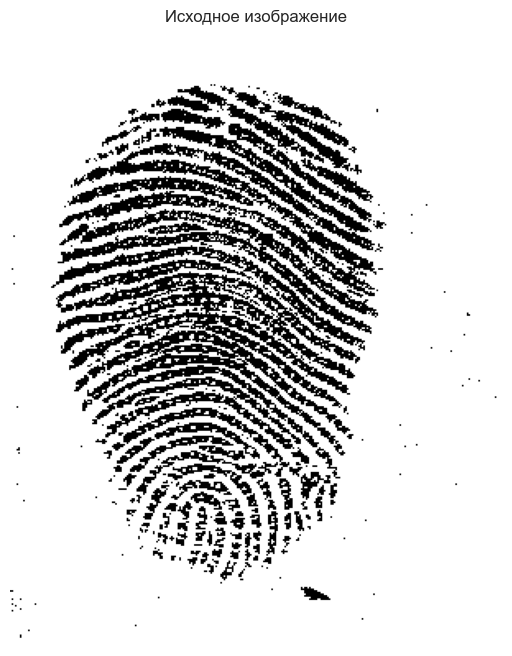


1. Метод квадратов (Box counting)
Фрактальная размерность (метод квадратов): 1.6020102790177224


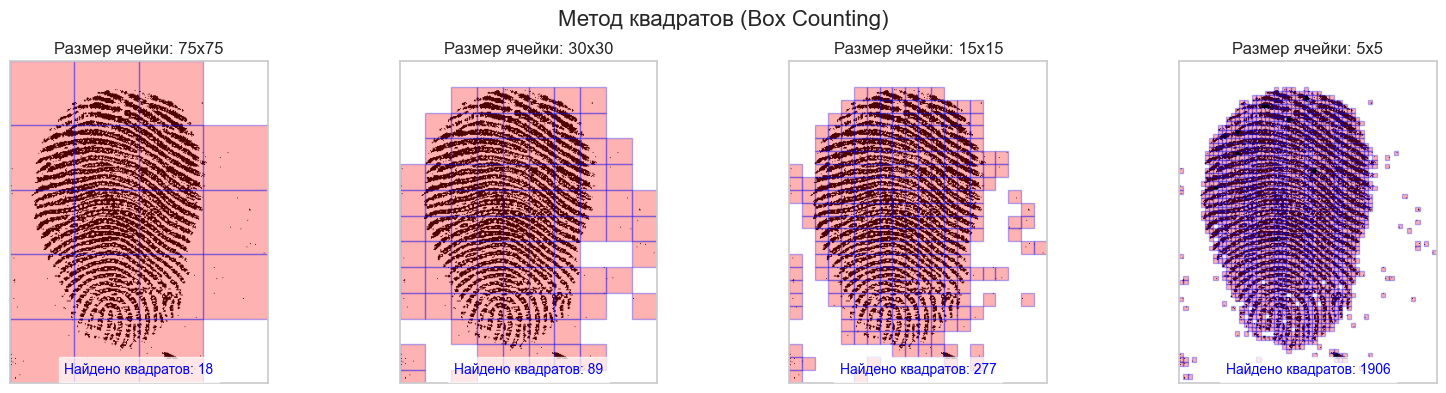


2. Метод кубов (3D Box counting)
Фрактальная размерность (метод кубов): 1.2994783702414598


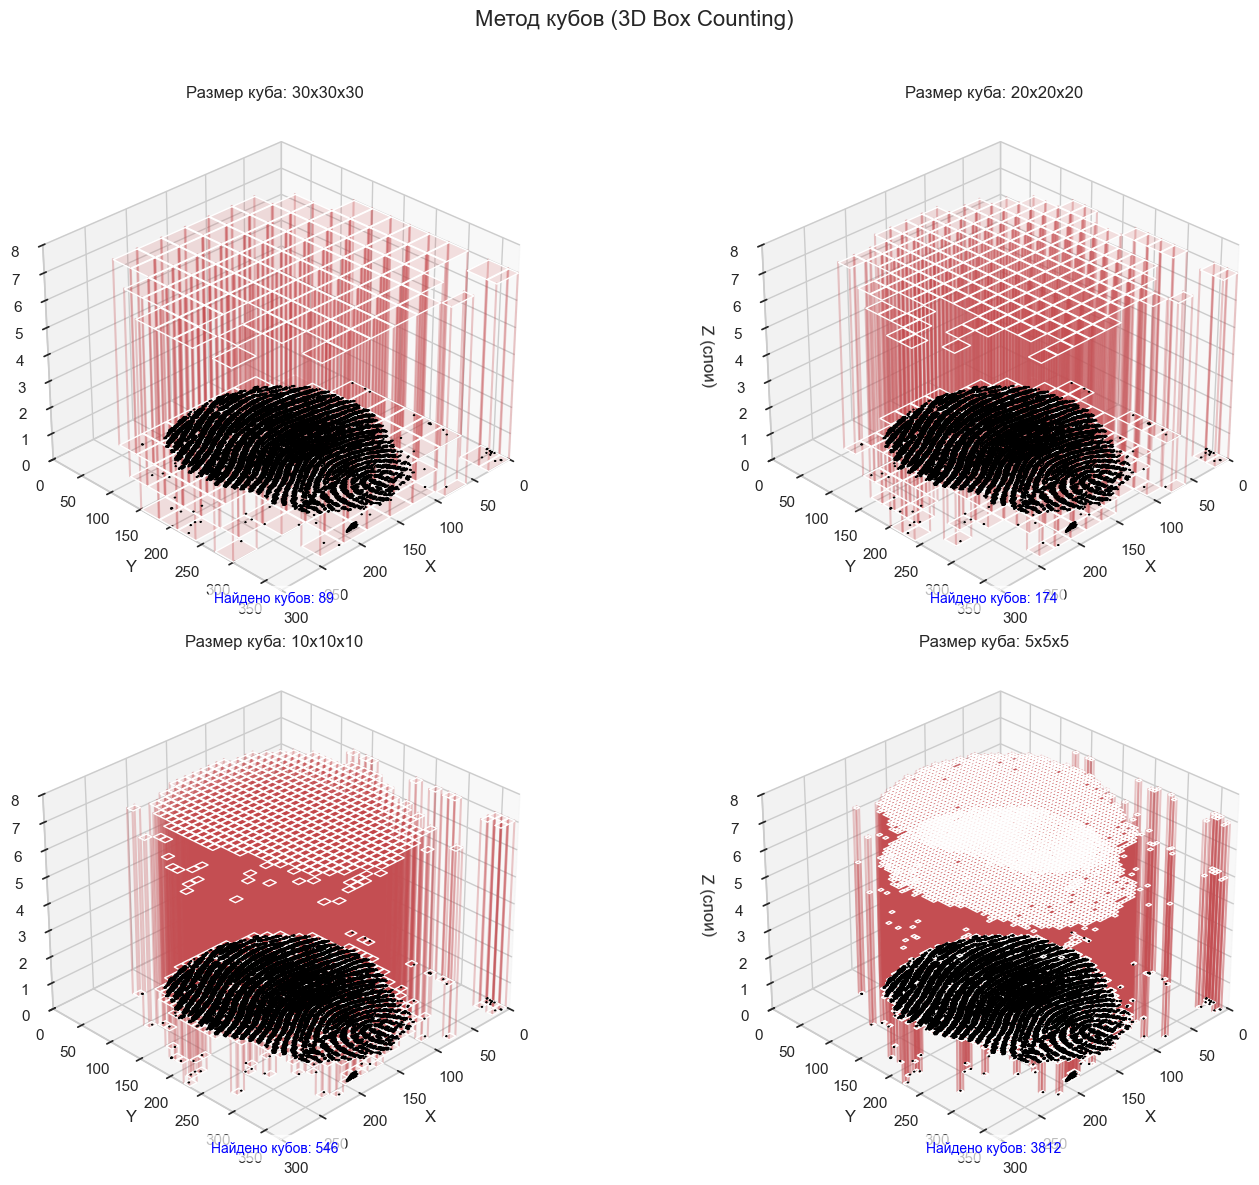


3. Метод триангуляции Делоне
Фрактальная размерность (метод триангуляции): 1.391402939644948


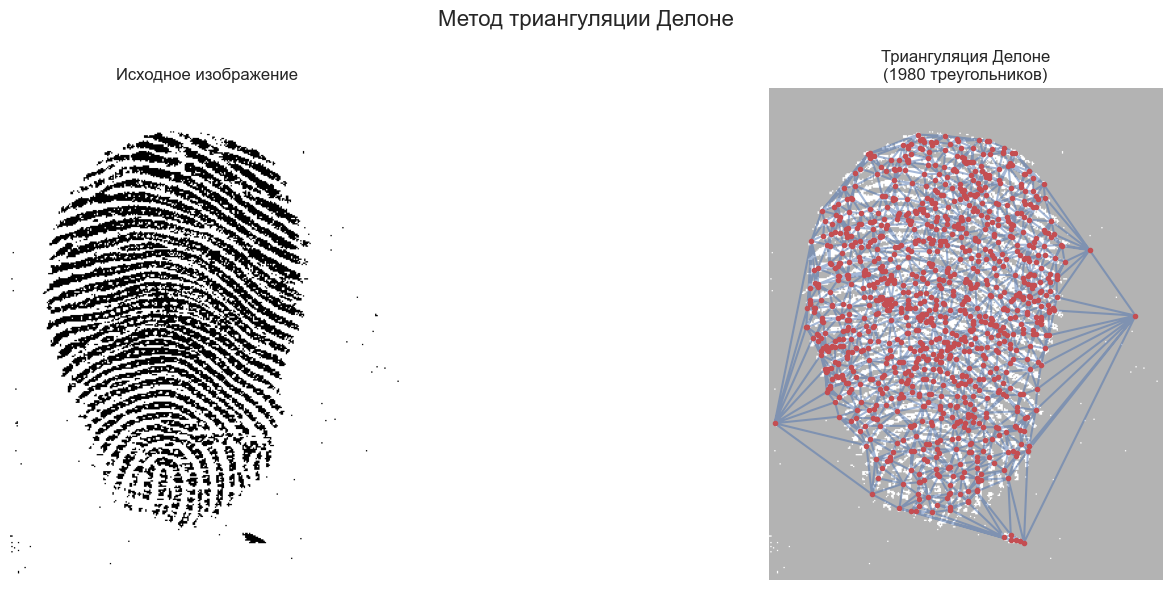


=== Сравнение результатов ===
Метод                     | Фрактальная размерность
--------------------------------------------------
Метод квадратов           | 1.6020
Метод кубов               | 1.2995
Метод триангуляции        | 1.3914


In [103]:
def visualize_box_counting(image: np.ndarray, threshold: float = 0.9) -> float:
    """
    Визуализирует процесс расчета фрактальной размерности методом квадратов.

    Параметры:
    - image: 2D-массив (изображение), значения от 0 до 1.
    - threshold: Порог для бинаризации.
    """
    # Бинаризация изображения
    binary_image = image < threshold

    # Рассчитываем фрактальную размерность
    fractal_dim = fractal_dimension_boxes(image, threshold)
    print(f"Фрактальная размерность (метод квадратов): {fractal_dim:}")

    # Размеры квадратов для визуализации
    sizes = [75, 30, 15, 5]
    xmin, xmax = 0, image.shape[1]
    ymin, ymax = 0, image.shape[0]

    # Создаем фигуру для визуализации
    fig, axes = plt.subplots(1, len(sizes), figsize=(16, 4))
    fig.suptitle("Метод квадратов (Box Counting)", fontsize=16)

    for i, size in enumerate(sizes):
        ax = axes[i]
        ax.imshow(image, cmap="gray", vmin=0, vmax=1,
                  extent=[xmin, xmax, ymin, ymax], origin="upper")

        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"Размер ячейки: {size}x{size}")

        # Добавляем квадраты, которые частично содержат объект
        count = 0
        for y in range(image.shape[0] // size + 1):
            for x in range(image.shape[1] // size + 1):
                # Вычисляем границы текущего квадрата
                y_start = y * size
                y_end = min((y + 1) * size, image.shape[0])
                x_start = x * size
                x_end = min((x + 1) * size, image.shape[1])

                # Проверяем содержимое квадрата
                box = binary_image[y_start:y_end, x_start:x_end]
                if np.any(box) and not np.all(box):
                    count += 1
                    rect = patches.Rectangle(
                        (x_start, image.shape[0] - y_end),
                        width=x_end - x_start,
                        height=y_end - y_start,
                        linewidth=1,
                        edgecolor="blue",
                        facecolor="red",
                        alpha=0.3)
                    ax.add_patch(rect)

        ax.text(0.5, 0.03, f"Найдено квадратов: {count}",
                transform=ax.transAxes,
                horizontalalignment="center",
                color="blue",
                fontsize=10,
                bbox=dict(facecolor="white", alpha=0.7))

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

    fig.savefig("images/box_counting_visualization.png", dpi=150, bbox_inches="tight")

    return fractal_dim


def visualize_cube_counting(image: np.ndarray, threshold: float = 0.9, max_layers: int = 8) -> float:
    """
    Визуализирует процесс расчета фрактальной размерности методом кубов.

    Параметры:
    - image: 2D-массив (изображение), значения от 0 до 1.
    - threshold: Порог для бинаризации.
    - max_layers: Количество слоев для 3D представления.
    """
    # Бинаризация изображения
    binary_image = image < threshold

    # Создаем 3D представление (height_map)
    height_map = np.zeros((*binary_image.shape, max_layers), dtype=np.uint8)
    for layer in range(max_layers):
        height_map[:, :, layer] = binary_image * (layer + 1)

    # Рассчитываем фрактальную размерность
    fractal_dim = fractal_dimension_cubes(image, threshold, max_layers)
    print(f"Фрактальная размерность (метод кубов): {fractal_dim}")

    # Размеры кубов для визуализации (должны быть меньше из-за 3D представления)
    sizes = [30, 20, 10, 5]

    # Создаем фигуру для визуализации
    fig = plt.figure(figsize=(16, 12))
    fig.suptitle("Метод кубов (3D Box Counting)", fontsize=16)

    # Готовим данные для 3D визуализации
    x_coords, y_coords = np.meshgrid(range(binary_image.shape[1]), range(binary_image.shape[0]))
    z_coords = np.zeros_like(x_coords)

    # Цветовая карта для бинарного изображения
    colors = np.zeros((*binary_image.shape, 4))  # RGBA
    colors[binary_image, 3] = 1.0  # Альфа-канал (прозрачность)

    for i, size in enumerate(sizes):
        ax = fig.add_subplot(2, 2, i + 1, projection="3d")
        ax.set_title(f"Размер куба: {size}x{size}x{size}")

        # Показываем базовое изображение как поверхность
        ax.plot_surface(x_coords, y_coords, z_coords,
                        facecolors=colors,
                        rstride=1, cstride=1,
                        antialiased=True, shade=False)

        # Добавляем кубы, которые частично содержат объект
        count = 0
        for y in range(0, binary_image.shape[0], size):
            for x in range(0, binary_image.shape[1], size):
                for z in range(0, max_layers, size):
                    # Вычисляем границы текущего куба
                    y_end = min(y + size, binary_image.shape[0])
                    x_end = min(x + size, binary_image.shape[1])
                    z_end = min(z + size, max_layers)

                    # Извлекаем значения внутри куба
                    cube = height_map[y:y_end, x:x_end, z:z_end]

                    # Проверяем, содержит ли куб объект частично
                    if np.any(cube) and not np.all(cube):
                        count += 1

                        # Добавляем куб на график (упрощенное представление как прямоугольник)
                        if binary_image[y:y_end, x:x_end].any():
                            # Создаем точки для куба
                            xx, yy = np.meshgrid([x, x_end - 1], [y, y_end - 1])

                            # Нижняя грань
                            bottom = np.zeros_like(xx)
                            ax.plot_surface(xx, yy, bottom, color="red", alpha=0.1)

                            # Верхняя грань
                            top = np.ones_like(xx) * min(z_end, max_layers - 1)
                            ax.plot_surface(xx, yy, top, color="red", alpha=0.1)

                            # Соединяем грани
                            for xi, yi in [(x, y), (x_end - 1, y), (x, y_end - 1), (x_end - 1, y_end - 1)]:
                                ax.plot([xi, xi], [yi, yi], [0, min(z_end, max_layers - 1)], "r-", alpha=0.3)

        ax.text2D(0.5, 0.03, f"Найдено кубов: {count}",
                  transform=ax.transAxes,
                  horizontalalignment="center",
                  color="blue",
                  fontsize=10,
                  bbox=dict(facecolor="white", alpha=0.7))

        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("Z (слои)")
        ax.set_xlim(0, binary_image.shape[1])
        ax.set_ylim(0, binary_image.shape[0])
        ax.set_zlim(0, max_layers)

        ax.view_init(elev=30, azim=45)

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

    fig.savefig("images/cube_counting_visualization.png", dpi=150, bbox_inches="tight")

    return fractal_dim


def visualize_triangulation(image: np.ndarray, threshold: float = 0.9) -> float:
    """
    Визуализирует процесс расчета фрактальной размерности методом триангуляции.

    Параметры:
    - image: 2D-массив (изображение), значения от 0 до 1.
    - threshold: Порог для бинаризации.
    """
    # Бинаризация изображения
    binary_image = image < threshold

    # Рассчитываем фрактальную размерность
    fractal_dim = fractal_dimension_triangulation(image, threshold)
    print(f"Фрактальная размерность (метод триангуляции): {fractal_dim:}")

    # Получаем координаты пикселей объекта
    points = np.argwhere(binary_image)

    # Для больших изображений берем подвыборку точек для ускорения
    if len(points) > 1000:
        indices = np.random.choice(len(points), 1000,
                                   replace=False)  # Случайная выборка из 1000 неповторяющихся элементов
        points = points[indices]

    # Выполняем триангуляцию Делоне
    try:
        tri = Delaunay(points)

        # Создаем фигуру для визуализации
        fig, axes = plt.subplots(1, 2, figsize=(18, 6))
        fig.suptitle("Метод триангуляции Делоне", fontsize=16)

        # 1. Показываем исходное изображение
        axes[0].imshow(image, cmap="gray")
        axes[0].set_title("Исходное изображение")
        axes[0].axis("off")

        # 2. Показываем точки и триангуляцию
        axes[1].imshow(binary_image, cmap="gray", alpha=0.3)
        axes[1].triplot(points[:, 1], points[:, 0], tri.simplices, "b-", alpha=0.5)
        axes[1].plot(points[:, 1], points[:, 0], "ro", markersize=3)
        axes[1].set_title(f"Триангуляция Делоне\n({len(tri.simplices)} треугольников)")
        axes[1].axis("off")

        plt.tight_layout()
        plt.subplots_adjust(top=0.85)
        plt.show()

        fig.savefig("images/triangulation_visualization.png", dpi=150, bbox_inches="tight")
    except Exception as e:
        print(f"Ошибка при построении триангуляции: {e}")
        # Показываем только исходное изображение
        plt.figure(figsize=(8, 6))
        plt.imshow(image, cmap="gray")
        plt.title("Исходное изображение")
        plt.axis("off")
        plt.show()

    return fractal_dim


def analyze_fractal_dimensions(image: np.ndarray, threshold: float = 0.9):
    """
    Выполняет анализ фрактальной размерности тремя методами и визуализирует результаты.

    Параметры:
    - image: 2D-массив (изображение), значения от 0 до 1.
    - threshold: Порог для бинаризации.
    """
    print("\n=== Анализ фрактальной размерности изображения ===\n")

    # Визуализируем исходное изображение
    plt.figure(figsize=(10, 8))
    plt.imshow(image, cmap="gray")
    plt.title("Исходное изображение")
    plt.axis("off")
    plt.show()

    # Визуализируем и рассчитываем фрактальную размерность каждым методом
    print("\n1. Метод квадратов (Box counting)")
    fd_boxes = visualize_box_counting(image, threshold)

    print("\n2. Метод кубов (3D Box counting)")
    fd_cubes = visualize_cube_counting(image, threshold)

    print("\n3. Метод триангуляции Делоне")
    fd_triangulation = visualize_triangulation(image, threshold)

    # Выводим сравнительную таблицу результатов
    print("\n=== Сравнение результатов ===")
    print(f"{'Метод':<25} | {'Фрактальная размерность':<20}")
    print("-" * 50)
    print(f"{'Метод квадратов':<25} | {fd_boxes:.4f}")
    print(f"{'Метод кубов':<25} | {fd_cubes:.4f}")
    print(f"{'Метод триангуляции':<25} | {fd_triangulation:.4f}")


if show_graphic_analysis:
    analyze_fractal_dimensions(image, threshold=0.25)

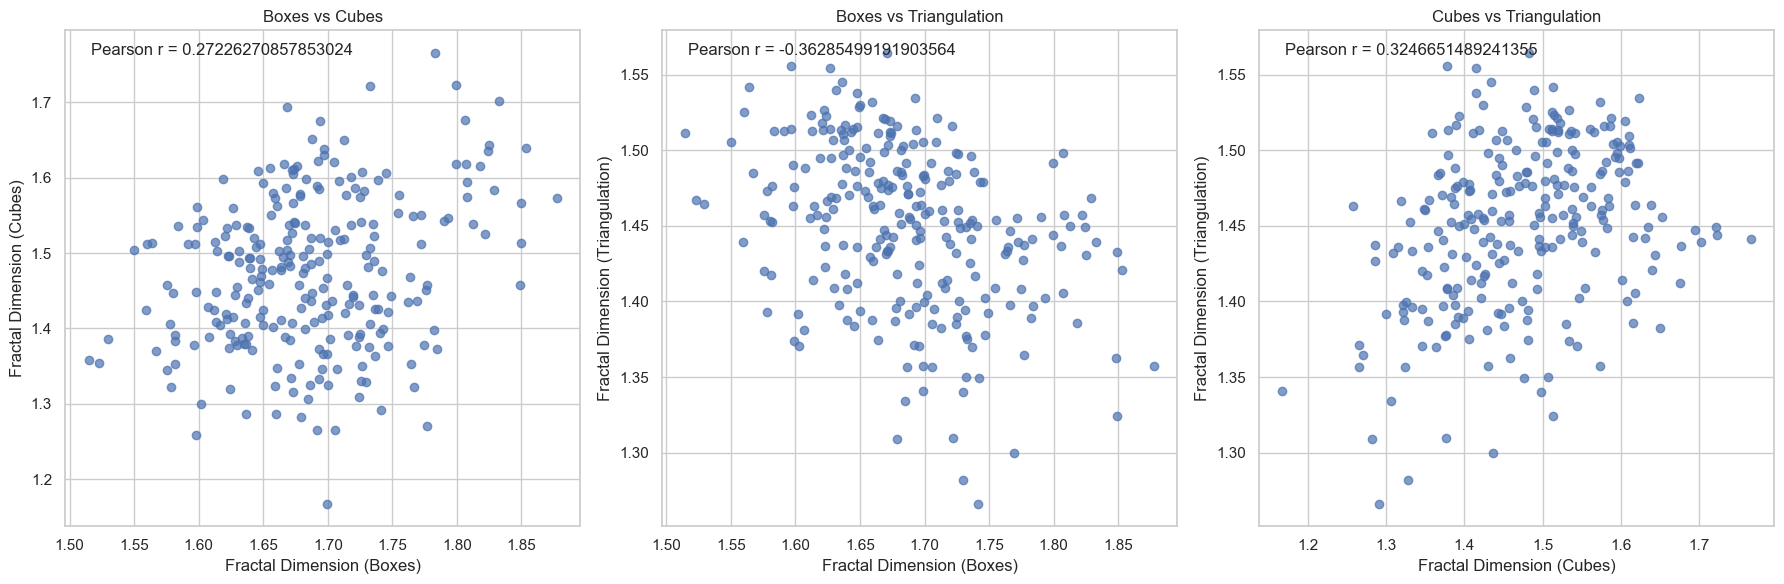

Коэффициенты корреляции Пирсона:
Boxes vs Cubes: 0.27226270857853024
Boxes vs Triangulation: -0.36285499191903564
Cubes vs Triangulation: 0.3246651489241355


In [104]:
# Построение диаграмм разброса и вычисление коэффициентов корреляции Пирсона
# r = (Σ (x_i - x̄)(y_i - ȳ)) / sqrt(Σ (x_i - x̄)² * Σ (y_i - ȳ)²)
# где x_i и y_i — значения фрактальных размерностей для каждой пары точек,
# x̄ и ȳ — их средние значения, а Σ означает суммирование по всем точкам.

plt.figure(figsize=(18, 6))

# Диаграмма 1: Boxes vs Cubes
plt.subplot(1, 3, 1)
plt.scatter(df["fractal_dimension_boxes"], df["fractal_dimension_cubes"], alpha=0.7)
plt.title("Boxes vs Cubes")
plt.xlabel("Fractal Dimension (Boxes)")
plt.ylabel("Fractal Dimension (Cubes)")
corr_boxes_cubes = df["fractal_dimension_boxes"].corr(df["fractal_dimension_cubes"], method="pearson")
plt.annotate(f"Pearson r = {corr_boxes_cubes:}",
             xy=(0.05, 0.95), xycoords="axes fraction", fontsize=12)

# Диаграмма 2: Boxes vs Triangulation
plt.subplot(1, 3, 2)
plt.scatter(df["fractal_dimension_boxes"], df["fractal_dimension_triangulation"], alpha=0.7)
plt.title("Boxes vs Triangulation")
plt.xlabel("Fractal Dimension (Boxes)")
plt.ylabel("Fractal Dimension (Triangulation)")
corr_boxes_tri = df["fractal_dimension_boxes"].corr(df["fractal_dimension_triangulation"], method="pearson")
plt.annotate(f"Pearson r = {corr_boxes_tri:}",
             xy=(0.05, 0.95), xycoords="axes fraction", fontsize=12)

# Диаграмма 3: Cubes vs Triangulation
plt.subplot(1, 3, 3)
plt.scatter(df["fractal_dimension_cubes"], df["fractal_dimension_triangulation"], alpha=0.7)
plt.title("Cubes vs Triangulation")
plt.xlabel("Fractal Dimension (Cubes)")
plt.ylabel("Fractal Dimension (Triangulation)")
corr_cubes_tri = df["fractal_dimension_cubes"].corr(df["fractal_dimension_triangulation"], method="pearson")
plt.annotate(f"Pearson r = {corr_cubes_tri:}",
             xy=(0.05, 0.95), xycoords="axes fraction", fontsize=12)

plt.tight_layout()
plt.savefig("images/scatter_plots.png")
plt.show()

print(f"Коэффициенты корреляции Пирсона:")
print(f"Boxes vs Cubes: {corr_boxes_cubes:}")
print(f"Boxes vs Triangulation: {corr_boxes_tri:}")
print(f"Cubes vs Triangulation: {corr_cubes_tri:}")

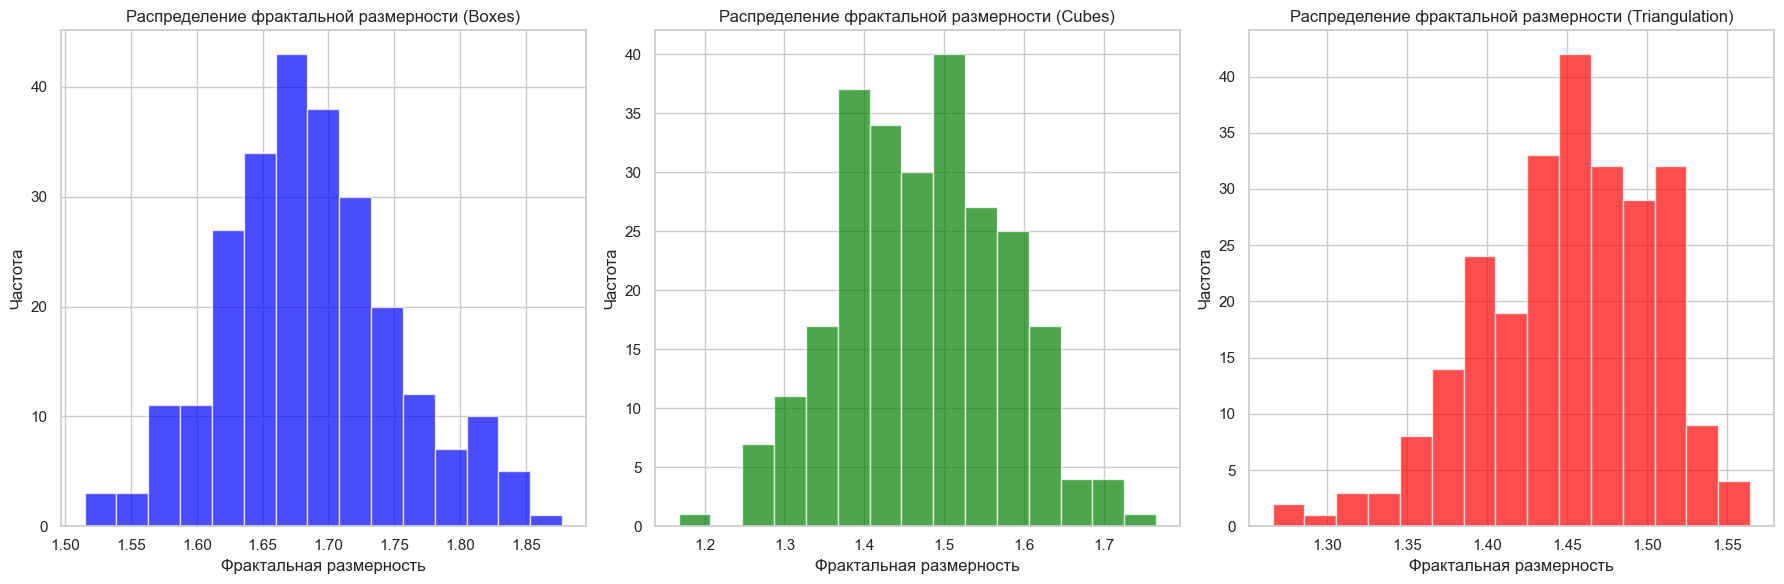

In [105]:
# Построение гистограмм распределения для всех трёх методов
plt.figure(figsize=(18, 6))

# Гистограмма для метода boxes
plt.subplot(1, 3, 1)
plt.hist(df["fractal_dimension_boxes"], bins=15, alpha=0.7, color="blue")
plt.title("Распределение фрактальной размерности (Boxes)")
plt.xlabel("Фрактальная размерность")
plt.ylabel("Частота")

# Гистограмма для метода cubes
plt.subplot(1, 3, 2)
plt.hist(df["fractal_dimension_cubes"], bins=15, alpha=0.7, color="green")
plt.title("Распределение фрактальной размерности (Cubes)")
plt.xlabel("Фрактальная размерность")
plt.ylabel("Частота")

# Гистограмма для метода triangulation
plt.subplot(1, 3, 3)
plt.hist(df["fractal_dimension_triangulation"], bins=15, alpha=0.7, color="red")
plt.title("Распределение фрактальной размерности (Triangulation)")
plt.xlabel("Фрактальная размерность")
plt.ylabel("Частота")

plt.tight_layout()
plt.savefig("images/histograms.png")
plt.show()

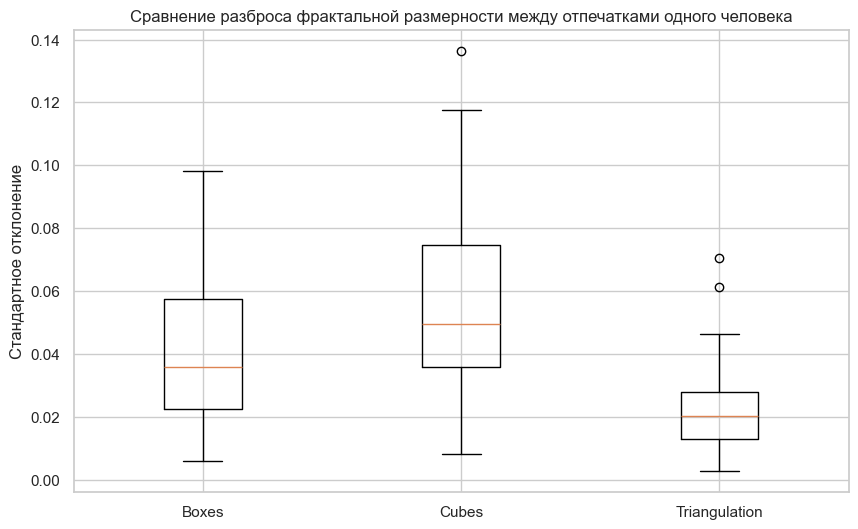

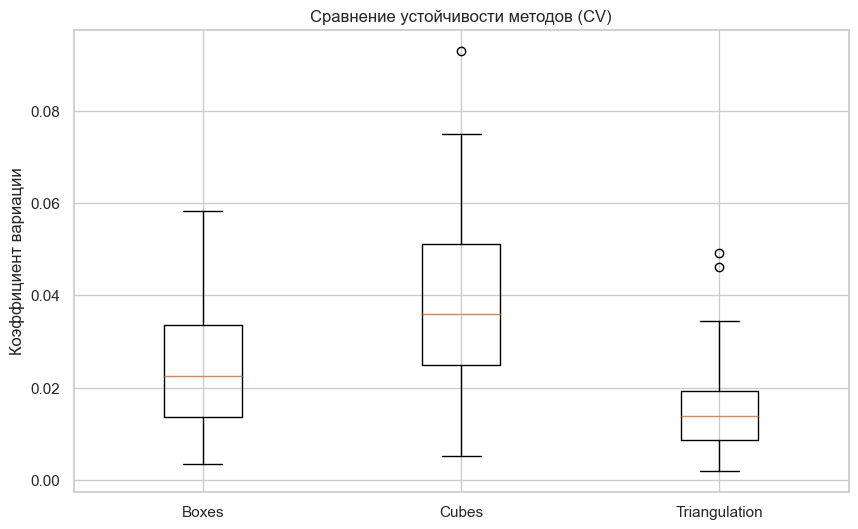

Boxes: Среднее σ = 0.03936556970211525, Средний CV = 0.02334447264556933
Cubes: Среднее σ = 0.05869733225296663, Средний CV = 0.04008410025667548
Triangulation: Среднее σ = 0.02262399805859108, Средний CV = 0.01582482883540204


In [106]:
# Считаем среднее значение и стандартное отклонение по каждому человеку
# X̄ = (X₁ + X₂ + ... + Xn) / n
# σ = √[(Σ(Xi - X̄)²) / (n - 1)]

stats = df.groupby("person_id").agg({
    "fractal_dimension_boxes": ["mean", "std"],
    "fractal_dimension_cubes": ["mean", "std"],
    "fractal_dimension_triangulation": ["mean", "std"]
})

# Преобразование названия колонок в вид единой строки
# Пример: ("fractal_dimension_boxes", "mean") в "fractal_dimension_boxes_mean"
stats.columns = ['_'.join(col) for col in stats.columns]
stats = stats.reset_index()

# Добавим коэффициент вариации (CV = std / mean)
for method in ["boxes", "cubes", "triangulation"]:
    stats[f"cv_{method}"] = stats[f"fractal_dimension_{method}_std"] / stats[f"fractal_dimension_{method}_mean"]

# -------- Визуализация: boxplot -------- #
plt.figure(figsize=(10, 6))
plt.boxplot([
    stats["fractal_dimension_boxes_std"],
    stats["fractal_dimension_cubes_std"],
    stats["fractal_dimension_triangulation_std"]
], tick_labels=["Boxes", "Cubes", "Triangulation"])
plt.ylabel("Стандартное отклонение")
plt.title("Сравнение разброса фрактальной размерности между отпечатками одного человека")
plt.grid(True)
plt.savefig("images/std_per_method_boxplot.png")
plt.show()

# -------- Визуализация: коэффициент вариации -------- #
plt.figure(figsize=(10, 6))
plt.boxplot([
    stats["cv_boxes"],
    stats["cv_cubes"],
    stats["cv_triangulation"]
], tick_labels=["Boxes", "Cubes", "Triangulation"])
plt.ylabel("Коэффициент вариации")
plt.title("Сравнение устойчивости методов (CV)")
plt.grid(True)
plt.savefig("images/cv_per_method_boxplot.png")
plt.show()

# -------- Вывод общих результатов -------- #
for method in ["boxes", "cubes", "triangulation"]:
    mean_std = stats[f"fractal_dimension_{method}_std"].mean()
    mean_cv = stats[f"cv_{method}"].mean()
    print(f"{method.capitalize()}: Среднее σ = {mean_std}, Средний CV = {mean_cv}")

**Диаграмма размаха (boxplot)** - показывает распределение стандартных отклонений для каждого метода фрактальной размерности. На графике:
- **Медиана (среднее значение)** будет отмечена линией внутри коробки.
- **Ящики** показывают диапазон, в котором находятся 50% значений (между 25-м и 75-м перцентилем).
- **Усы** показывают диапазон значений, которые не считаются выбросами.
- **Выбросы** (точки за пределами усов) показывают аномально высокие или низкие значения.

In [111]:
methods = ["boxes", "cubes", "triangulation"]
result_df = pd.DataFrame(columns=[
    "person_id",
    "boxes_overlap_count",
    "cubes_overlap_count",
    "triangulation_overlap_count"
])

for person_id, group in df.groupby("person_id"):
    new_row = {"person_id": person_id}

    for method in methods:
        values = group[f"fractal_dimension_{method}"].values

        group_count = len(values) // 5
        intervals = []

        for i in range(group_count):
            subset = values[i*5:(i+1)*5]
            mean = np.mean(subset)
            std = np.std(subset)
            intervals.append((mean - std, mean + std))

        # Подсчёт наложений между интервалами
        overlap_count = 0
        for (a1, a2), (b1, b2) in combinations(intervals, 2):
            if max(a1, b1) <= min(a2, b2):
                overlap_count += 1

        new_row[f"{method}_overlap_count"] = overlap_count

    result_df.loc[len(result_df)] = new_row

result_df

,person_id,boxes_overlap_count,cubes_overlap_count,triangulation_overlap_count
0,1,0,0,0
1,2,0,0,0
2,3,0,0,0
3,4,0,0,0
4,5,0,0,0
5,6,0,0,0
6,7,0,0,0
7,8,0,0,0
8,9,0,0,0
9,10,0,0,0


In [108]:
# Сумма наложений по каждому методу
print("\nСуммарное количество наложений:")
print("Boxes:", result_df["boxes_overlap_count"].sum())
print("Cubes:", result_df["cubes_overlap_count"].sum())
print("Triangulation:", result_df["triangulation_overlap_count"].sum())


Суммарное количество наложений:
Boxes: 0
Cubes: 0
Triangulation: 0
